# House Data Analysis - Fortaleza/CE Brazil

## 1. Importing packages

In [1]:
import requests
import pandas as pd
from pandas_profiling import ProfileReport
import time
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pycep_correios
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from scipy import stats
import warnings
import math
warnings.filterwarnings('ignore')

## 2. Loading the data from CSV File

### 2.1 Loading the data using pandas and creating a DataFrame

In [2]:
df_Properties = pd.read_csv('./Resources/olx_Fortaleza_220830.csv')


### 2.2 Looking how our dataset looks like 
 

In [3]:
df_Properties.head()

,Category,Type,Cond_Price,IPTU_Price,Area,Bedrooms,Bathrooms,Garage,Property_Detail,Cond_Detail,Price,Zipcode,City,Neighboor,Address,Description
0,Apartamentos,Venda - apartamento padrão,R$ 790,R$ 1.200,110m²,3,4,2,"Mobiliado, Piscina, Ar condicionado, Varanda, ...","Salão de festas, Condomínio fechado, Permitido...",R$ 690.000,60110370,Fortaleza,Meireles,Rua Antônio Augusto - até 909/910,Código do anúncio: LC0013\n\nConheça o Marbell...
1,Apartamentos,Venda - apartamento padrão,R$ 0,R$ 0,54m²,2,2,2,"Churrasqueira, Piscina, Ar condicionado","Piscina, Elevador",R$ 499.000,60812260,Fortaleza,Edson Queiroz,Travessa Contaneide,Código do anúncio: AP0389\n\nEmpreendimento es...
2,Apartamentos,Venda - apartamento padrão,R$ 450,R$ 0,82m²,3,3,2,"Churrasqueira, Área de serviço, Piscina","Piscina, Elevador",R$ 650.000,60810220,Fortaleza,Engenheiro Luciano Cavalcante,Rua Gontran Giffoni,Código do anúncio: AP0521\n\nExcelente apartam...
3,Casas,Venda - casa em rua pública,R$ 0,R$ 0,145m²,3,2,0,NaN,Permitido animais,R$ 275.000,60050040,Fortaleza,Centro,Rua Solon Pinheiro - até 589/590,"Código do anúncio: fc35f6\n\nCasa, excelente p..."
4,Apartamentos,Venda - apartamento padrão,R$ 322,R$ 0,58m²,2,2,1,"Churrasqueira, Piscina",Piscina,R$ 450.000,60824030,Fortaleza,Parque Iracema,Rua Mauro Freire,Código do anúncio: DAVila_1-2318156\n\nCondomí...


In [4]:
df_Properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4983 entries, 0 to 4982
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         4983 non-null   object
 1   Type             4983 non-null   object
 2   Cond_Price       4830 non-null   object
 3   IPTU_Price       4735 non-null   object
 4   Area             4904 non-null   object
 5   Bedrooms         4983 non-null   object
 6   Bathrooms        4970 non-null   object
 7   Garage           4800 non-null   object
 8   Property_Detail  3665 non-null   object
 9   Cond_Detail      3546 non-null   object
 10  Price            4967 non-null   object
 11  Zipcode          4983 non-null   int64 
 12  City             4983 non-null   object
 13  Neighboor        4983 non-null   object
 14  Address          4931 non-null   object
 15  Description      4983 non-null   object
dtypes: int64(1), object(15)
memory usage: 623.0+ KB


## 3. Exploratory Data Analysis

### 3.1 Remove Duplicated Rows

In [6]:
df_Properties2 = df_Properties.drop_duplicates()
print("Duplicated Lines Removed: "+ str(df_Properties.shape[0] - df_Properties2.shape[0]))

Duplicated Lines Removed: 35


### 3.2 Check for missing values

<AxesSubplot:>

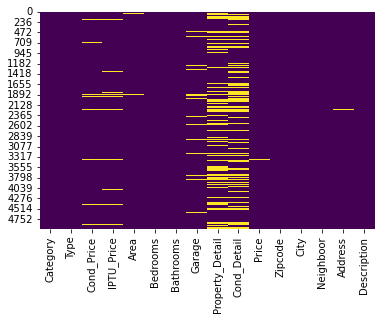

In [7]:
#Let's analyze the distribution of missing values
sns.heatmap(df_Properties2.isnull(),cbar=False,cmap='viridis')

### 3.3 Dealing with missing values

<AxesSubplot:>

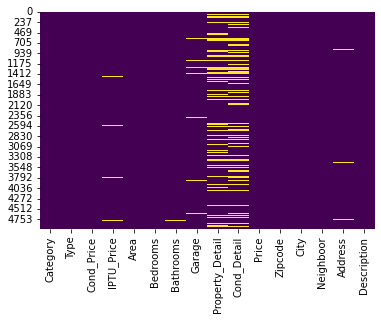

In [8]:
#For a good analysis of the houses I believe some very important information is the Price and the Area
#So let's remove the lines with null information in price and area
df_Properties2 = df_Properties2[~df_Properties2['Price'].isnull()]
df_Properties2 = df_Properties2[~df_Properties2['Area'].isnull()]
sns.heatmap(df_Properties2.isnull(),cbar=False,cmap='viridis')

In [10]:
#Let's analyze the columns IPTU price that is relative to the value of tax over property that need be paid every year to the goverment
df_Properties2['IPTU_Price'].value_counts()

R$ 0        3787
R$ 1          80
R$ 1.200      27
R$ 800        26
R$ 600        21
            ... 
R$ 1.498       1
R$ 652         1
R$ 67          1
R$ 1.130       1
R$ 716         1
Name: IPTU_Price, Length: 389, dtype: int64

In [11]:
#Let's analyze the columns Cond_Price that is relative to the value of monthly payment for the use of the amendments
#In the properties that are located inside home condominium
df_Properties2['Cond_Price'].value_counts()

R$ 0          1853
R$ 700          96
R$ 1.100        84
R$ 600          83
R$ 500          79
              ... 
R$ 2.104         1
R$ 1.420         1
R$ 2.161         1
R$ 996           1
R$ 110.000       1
Name: Cond_Price, Length: 584, dtype: int64

In [15]:
#We saw that IPTU_Price and Cond_Price has a lot of zero values, for the IPTU column it is really strange, because every property must pay it
#But for Cond_Price, there is some properties that are not located inside a condominium and do not need pay it
#So let's check how these zero values are distributed
df_Properties2[df_Properties2['Cond_Price'] == 'R$ 0'].groupby('Type')['Price'].count()

Type
Venda - apartamento cobertura          14
Venda - apartamento padrão            960
Venda - casa em condominio fechado     59
Venda - casa em rua pública           805
Venda - casa em vila                    2
Venda - loft/studio                    13
Name: Price, dtype: int64

In [16]:
#After evaluation only 'Type' values 'Venda - casa em rua pública' and 'Venda - casa em vila' could not have the Cond_Price, but we saw too many others also with R$ 0
#So in this case it is better drop Cond_Price and also IPTU_Price for our analysis
#Too many zero values, it is better we drop this column
df_Properties2.drop(['Cond_Price'
                     ,'IPTU_Price'
                     ],axis=1, inplace=True)

In [17]:
df_Properties2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4862 entries, 0 to 4982
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         4862 non-null   object
 1   Type             4862 non-null   object
 2   Area             4862 non-null   object
 3   Bedrooms         4862 non-null   object
 4   Bathrooms        4853 non-null   object
 5   Garage           4701 non-null   object
 6   Property_Detail  3607 non-null   object
 7   Cond_Detail      3502 non-null   object
 8   Price            4862 non-null   object
 9   Zipcode          4862 non-null   int64 
 10  City             4862 non-null   object
 11  Neighboor        4862 non-null   object
 12  Address          4819 non-null   object
 13  Description      4862 non-null   object
dtypes: int64(1), object(13)
memory usage: 569.8+ KB


In [19]:
#Evaluating the columns Category and Type, looks like Type is a subcategory of each Category
df_Properties2.groupby(['Category','Type'])['Price'].count()

Category      Type                              
Apartamentos  Venda - apartamento cobertura           52
              Venda - apartamento duplex/triplex       2
              Venda - apartamento kitchenette          4
              Venda - apartamento padrão            3550
              Venda - loft/studio                     39
Casas         Venda - casa em condominio fechado     299
              Venda - casa em rua pública            912
              Venda - casa em vila                     4
Name: Price, dtype: int64

In [ ]:
#So we can see the Type values in the Category 'Apartamentos' are different from the Type values in the category 'Casas' so for our analysis only the Type column is enough

In [11]:
#Separating the number from the currency symbol, so later we can transform to a numeric column
df_Properties2[['Price_Currency','Price_Value']] = df_Properties2["Price"].str.split(expand = True)
df_Properties2[['Cond_Currency','Cond_Value']] = df_Properties2["Cond_Price"].str.split(expand = True)
df_Properties2[['IPTU_Currency','IPTU_Value']] = df_Properties2["IPTU_Price"].str.split(expand = True)

In [12]:
df_Properties2[['Price_Currency','Price_Value','Cond_Currency','Cond_Value','IPTU_Currency','IPTU_Value']].head()

,Price_Currency,Price_Value,Cond_Currency,Cond_Value,IPTU_Currency,IPTU_Value
0,R$,569.000,R$,0,R$,0
1,R$,1.350.000,R$,449,NaN,NaN
2,R$,995.000,R$,850,R$,0
3,R$,4.000.000,R$,1.150,R$,0
4,R$,35.000,R$,0,R$,0


In [13]:
#Transforming the value columns into numeric columns
df_Properties2['Price_Value'] = pd.to_numeric(df_Properties2["Price_Value"].str.replace('.',''))
df_Properties2['Cond_Value'] = pd.to_numeric(df_Properties2["Cond_Value"].str.replace('.',''))
df_Properties2['IPTU_Value'] = pd.to_numeric(df_Properties2["IPTU_Value"].str.replace('.',''))

In [14]:
df_Properties2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9908 entries, 0 to 9976
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         9908 non-null   object 
 1   Type             9908 non-null   object 
 2   Cond_Price       9490 non-null   object 
 3   IPTU_Price       9235 non-null   object 
 4   Area             9731 non-null   object 
 5   Bedrooms         9908 non-null   object 
 6   Bathrooms        9886 non-null   object 
 7   Garage           9526 non-null   object 
 8   Property_Detail  7190 non-null   object 
 9   Cond_Detail      6838 non-null   object 
 10  Price            9879 non-null   object 
 11  Zipcode          9908 non-null   int64  
 12  City             9908 non-null   object 
 13  Neighboor        6482 non-null   object 
 14  Address          6355 non-null   object 
 15  Description      9908 non-null   object 
 16  Price_Currency   9879 non-null   object 
 17  Price_Value   

In [15]:
#Create new numeric column with the value of the area is square meters
df_Properties2["Area_value"] = pd.to_numeric(df_Properties2["Area"].str.replace('m²',''))

In [16]:
df_Properties2.head()

,Category,Type,Cond_Price,IPTU_Price,Area,Bedrooms,Bathrooms,Garage,Property_Detail,Cond_Detail,...,Neighboor,Address,Description,Price_Currency,Price_Value,Cond_Currency,Cond_Value,IPTU_Currency,IPTU_Value,Area_value
0,Casas,Venda - casa em condominio fechado,R$ 0,R$ 0,150m²,4,4,2,"Churrasqueira, Piscina, Área de serviço, Ar co...","Piscina, Condomínio fechado",...,NaN,NaN,Código do anúncio: CA0565\n\nRef.:5435 - Um lu...,R$,569000.0,R$,0.0,R$,0.0,150.0
1,Casas,Venda - casa em condominio fechado,R$ 449,NaN,230m²,4,5 ou mais,4,"Área de serviço, Varanda, Churrasqueira","Condomínio fechado, Segurança 24h, Área murada...",...,NaN,NaN,UMA CIDADE PENSADA PARA VOCÊ\n\nOcupando mais ...,R$,1350000.0,R$,449.0,NaN,NaN,230.0
2,Casas,Venda - casa em condominio fechado,R$ 850,R$ 0,210m²,4,4,3,"Porteiro 24h, Varanda, Ar condicionado","Permitido animais, Portão eletrônico",...,NaN,NaN,Código do anúncio: EUSEBIO1\n\nA casa de condo...,R$,995000.0,R$,850.0,R$,0.0,210.0
3,Casas,Venda - casa em condominio fechado,R$ 1.150,R$ 0,335m²,4,4,4,"Piscina, Área de serviço",Piscina,...,NaN,NaN,Código do anúncio: 85\n\nALPHAVILLE - FORTALEZ...,R$,4000000.0,R$,1150.0,R$,0.0,335.0
4,Apartamentos,Venda - apartamento padrão,R$ 0,R$ 0,50m²,2,1,1,NaN,NaN,...,Parque Guadalajara (Jurema),Rua Poebla,Código do anúncio: 1M0JU63\n\nRepasse no Potir...,R$,35000.0,R$,0.0,R$,0.0,50.0


In [17]:
#Evaluating the different values and its quantities in the Bedrooms column
df_Properties2['Bedrooms'].value_counts()

3            4753
2            2428
4            1922
5 ou mais     590
1             207
0               8
Name: Bedrooms, dtype: int64

In [18]:
#Looking to the columns Bathrooms and Garage we noted they have the same format as the Bedroom column
#So we are creating new columns with numeric values
df_Properties2['Bedrooms_qty'] = pd.to_numeric(df_Properties2["Bedrooms"].str.replace(' ou mais',''))
df_Properties2['Bathrooms_qty'] = pd.to_numeric(df_Properties2["Bathrooms"].str.replace(' ou mais',''))
df_Properties2['Garage_qty'] = pd.to_numeric(df_Properties2["Garage"].str.replace(' ou mais',''))

In [19]:
df_Properties2.head()

,Category,Type,Cond_Price,IPTU_Price,Area,Bedrooms,Bathrooms,Garage,Property_Detail,Cond_Detail,...,Price_Currency,Price_Value,Cond_Currency,Cond_Value,IPTU_Currency,IPTU_Value,Area_value,Bedrooms_qty,Bathrooms_qty,Garage_qty
0,Casas,Venda - casa em condominio fechado,R$ 0,R$ 0,150m²,4,4,2,"Churrasqueira, Piscina, Área de serviço, Ar co...","Piscina, Condomínio fechado",...,R$,569000.0,R$,0.0,R$,0.0,150.0,4,4.0,2.0
1,Casas,Venda - casa em condominio fechado,R$ 449,NaN,230m²,4,5 ou mais,4,"Área de serviço, Varanda, Churrasqueira","Condomínio fechado, Segurança 24h, Área murada...",...,R$,1350000.0,R$,449.0,NaN,NaN,230.0,4,5.0,4.0
2,Casas,Venda - casa em condominio fechado,R$ 850,R$ 0,210m²,4,4,3,"Porteiro 24h, Varanda, Ar condicionado","Permitido animais, Portão eletrônico",...,R$,995000.0,R$,850.0,R$,0.0,210.0,4,4.0,3.0
3,Casas,Venda - casa em condominio fechado,R$ 1.150,R$ 0,335m²,4,4,4,"Piscina, Área de serviço",Piscina,...,R$,4000000.0,R$,1150.0,R$,0.0,335.0,4,4.0,4.0
4,Apartamentos,Venda - apartamento padrão,R$ 0,R$ 0,50m²,2,1,1,NaN,NaN,...,R$,35000.0,R$,0.0,R$,0.0,50.0,2,1.0,1.0


In [20]:
df_Properties2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9908 entries, 0 to 9976
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         9908 non-null   object 
 1   Type             9908 non-null   object 
 2   Cond_Price       9490 non-null   object 
 3   IPTU_Price       9235 non-null   object 
 4   Area             9731 non-null   object 
 5   Bedrooms         9908 non-null   object 
 6   Bathrooms        9886 non-null   object 
 7   Garage           9526 non-null   object 
 8   Property_Detail  7190 non-null   object 
 9   Cond_Detail      6838 non-null   object 
 10  Price            9879 non-null   object 
 11  Zipcode          9908 non-null   int64  
 12  City             9908 non-null   object 
 13  Neighboor        6482 non-null   object 
 14  Address          6355 non-null   object 
 15  Description      9908 non-null   object 
 16  Price_Currency   9879 non-null   object 
 17  Price_Value   

In [21]:
#Let's look to the Category Column
df_Properties2['Category'].value_counts()

Apartamentos    4964
Casas           4944
Name: Category, dtype: int64

In [25]:
#Let's look to the Type Column
df_Properties2['Type'].value_counts()

Venda - apartamento padrão            4750
Venda - casa em rua pública           3022
Venda - casa em condominio fechado    1900
Venda - apartamento cobertura          143
Venda - loft/studio                     51
Venda - casa em vila                    22
Venda - apartamento duplex/triplex      14
Venda - apartamento kitchenette          6
Name: Type, dtype: int64

In [27]:
#Let's look to the Cond_Detail Column
df_Properties2['Cond_Detail']

0                             Piscina, Condomínio fechado
1       Condomínio fechado, Segurança 24h, Área murada...
2                    Permitido animais, Portão eletrônico
3                                                 Piscina
4                                                     NaN
                              ...                        
9972                                    Permitido animais
9973                                                  NaN
9974    Portaria, Piscina, Permitido animais, Salão de...
9975                                              Piscina
9976    Permitido animais, Piscina, Academia, Salão de...
Name: Cond_Detail, Length: 9908, dtype: object

In [28]:
#Let's look to the Property_Detail Column
df_Properties2['Property_Detail']

0       Churrasqueira, Piscina, Área de serviço, Ar co...
1                 Área de serviço, Varanda, Churrasqueira
2                  Porteiro 24h, Varanda, Ar condicionado
3                                Piscina, Área de serviço
4                                                     NaN
                              ...                        
9972    Armários embutidos, Armários na cozinha, Área ...
9973                                                  NaN
9974          Mobiliado, Piscina, Academia, Churrasqueira
9975                    Piscina, Varanda, Área de serviço
9976            Piscina, Churrasqueira, Academia, Varanda
Name: Property_Detail, Length: 9908, dtype: object

In [29]:
#Let's look to the City Column
df_Properties2['City'].value_counts()

Fortaleza                  4948
Eusébio                    2387
Aquiraz                     976
Caucaia                     721
Maracanaú                   348
Itaitinga                   262
Pacatuba                    114
Maranguape                   57
São Gonçalo do Amarante      47
Cascavel                     19
Horizonte                     9
Pindoretama                   9
Pacajus                       6
Pavuna, Pacatuba              2
Monguba, Pacatuba             1
João de Castro                1
Caponga, Cascavel             1
Name: City, dtype: int64

In [41]:
#I will remove the cities with less than 20 properties
df_Properties3 = df_Properties2[~df_Properties2['City'].isin( ['Caponga, Cascavel'
                                                               ,'João de Castro'
                                                               ,'Monguba, Pacatuba'
                                                               ,'Pavuna, Pacatuba'
                                                               ,'Pacajus'
                                                               ,'Pindoretama'
                                                               ,'Horizonte'
                                                               ,'Cascavel'])]
df_Properties3['City'].value_counts()

Fortaleza                  4948
Eusébio                    2387
Aquiraz                     976
Caucaia                     721
Maracanaú                   348
Itaitinga                   262
Pacatuba                    114
Maranguape                   57
São Gonçalo do Amarante      47
Name: City, dtype: int64

In [45]:
#Drop the rows that have null values of Area and Price
df_Properties3 = df_Properties3[df_Properties3['Area_value'].notnull()]
df_Properties3 = df_Properties3[df_Properties3['Price_Value'].notnull()]
#Drop unecessary columns as 'Cond_Price','IPTU_Price', 'Area', 'Bedrooms', 'Bathrooms',
#'Garage, 'Price', 'Description', 'Price_Currency', 'Cond_Currency', 'IPTU_Currency'
df_Properties3.drop(['Cond_Price'
                     ,'IPTU_Price'
                     , 'Area'
                     , 'Bedrooms'
                     , 'Bathrooms'
                     ,'Garage'
                     , 'Price'
                     , 'Description'
                     , 'Price_Currency'
                     , 'Cond_Currency'
                     , 'IPTU_Currency'],axis=1, inplace=True)
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9677 entries, 0 to 9976
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         9677 non-null   object 
 1   Type             9677 non-null   object 
 2   Property_Detail  7080 non-null   object 
 3   Cond_Detail      6748 non-null   object 
 4   Zipcode          9677 non-null   int64  
 5   City             9677 non-null   object 
 6   Neighboor        6319 non-null   object 
 7   Address          6211 non-null   object 
 8   Price_Value      9677 non-null   float64
 9   Cond_Value       9422 non-null   float64
 10  IPTU_Value       9183 non-null   float64
 11  Area_value       9677 non-null   float64
 12  Bedrooms_qty     9677 non-null   int64  
 13  Bathrooms_qty    9663 non-null   float64
 14  Garage_qty       9339 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 1.2+ MB


In [46]:
df_Properties3.Cond_Value.value_counts()

0.0         4833
500.0        162
600.0        154
1000.0       133
700.0        129
            ... 
222.0          1
1847.0         1
1097.0         1
155000.0       1
110000.0       1
Name: Cond_Value, Length: 717, dtype: int64

In [47]:
df_Properties3.IPTU_Value.value_counts()

0.0        7322
1.0         282
200.0        76
150.0        50
1200.0       47
           ... 
228.0         1
927.0         1
410.0         1
15275.0       1
716.0         1
Name: IPTU_Value, Length: 512, dtype: int64

In [48]:
#Too many zero values in the Cond_Value and also in the IPTU_Value so lets also drop these 2 columns
df_Properties3.drop(['Cond_Value'
                     ,'IPTU_Value'],axis=1, inplace=True)
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9677 entries, 0 to 9976
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         9677 non-null   object 
 1   Type             9677 non-null   object 
 2   Property_Detail  7080 non-null   object 
 3   Cond_Detail      6748 non-null   object 
 4   Zipcode          9677 non-null   int64  
 5   City             9677 non-null   object 
 6   Neighboor        6319 non-null   object 
 7   Address          6211 non-null   object 
 8   Price_Value      9677 non-null   float64
 9   Area_value       9677 non-null   float64
 10  Bedrooms_qty     9677 non-null   int64  
 11  Bathrooms_qty    9663 non-null   float64
 12  Garage_qty       9339 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage: 1.0+ MB


In [52]:
#looks like Type column is a subset of the Category column so lets check
df_Properties3.groupby(['Category','Type'])['Zipcode'].count()

Category      Type                              
Apartamentos  Venda - apartamento cobertura          142
              Venda - apartamento duplex/triplex      13
              Venda - apartamento kitchenette          6
              Venda - apartamento padrão            4697
              Venda - loft/studio                     51
Casas         Venda - casa em condominio fechado    1875
              Venda - casa em rua pública           2879
              Venda - casa em vila                    14
Name: Zipcode, dtype: int64

In [63]:
#As we can see above the Type in Category 'Apartamentos' 
#are different of the Type in the Category 'Casas' so the information 
#in these columns are redundant, so we can drop the columns 'Category'
df_Properties3.drop(['Category'],axis=1, inplace=True)
df_Properties3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9677 entries, 0 to 9976
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                9677 non-null   object 
 1   Property_Detail     7080 non-null   object 
 2   Cond_Detail         6748 non-null   object 
 3   Zipcode             9677 non-null   int64  
 4   City                9677 non-null   object 
 5   Neighboor           6319 non-null   object 
 6   Address             6211 non-null   object 
 7   Price_Value         9677 non-null   float64
 8   Area_value          9677 non-null   float64
 9   Bedrooms_qty        9677 non-null   int64  
 10  Bathrooms_qty       9663 non-null   float64
 11  Garage_qty          9339 non-null   float64
 12  Price_Square_Meter  9677 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 1.0+ MB


In [67]:
#Lets drop the lines where the Area_value is less than 50 square meters
df_Properties3 = df_Properties3[df_Properties3['Area_value'] >= 50]
#Lets create the columns of value per square meter
df_Properties3['Price_Square_Meter'] = df_Properties3['Price_Value']/df_Properties3['Area_value']

<AxesSubplot:>

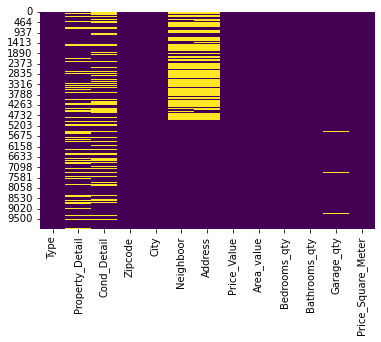

In [87]:
#Let's analyze the distribution of missing values
sns.heatmap(df_Properties3.isnull(),cbar=False,cmap='viridis')

In [100]:
#With the heatmap above we can see the columns Property_Detail, Cond_Detail, Neighboor, Adress and Garage_qty has some missing values
#Let's deal one by one
#For the Garage_qty we can consider if the information was not provided it means there is no garage and we will fill with zero
df_Properties3['Garage_qty'] = df_Properties3['Garage_qty'].apply(lambda x: x if not math.isnan(x) else 0)

In [103]:
#For Cond_detail it is about details of amendments in the condominium, so it only makes sense for properties inside a condominium, so lets check it
df_Properties3[df_Properties3['Cond_Detail'].isnull()]['Type'].value_counts()

Venda - casa em rua pública           1810
Venda - apartamento padrão             794
Venda - casa em condominio fechado     162
Venda - apartamento cobertura           17
Venda - casa em vila                     3
Venda - loft/studio                      2
Name: Type, dtype: int64

In [104]:
#So looking the information above we can see the most properties without condominium details is really the ones that is not in a condominium, so in this case 
#since we cannot determine the properties amendments we will consider the properties that did not list do not have it and later we will create new columns for these amendments
#Lets chech about properties details
df_Properties3[df_Properties3['Property_Detail'].isnull()]['Type'].value_counts()

Venda - casa em rua pública           1360
Venda - apartamento padrão             828
Venda - casa em condominio fechado     224
Venda - apartamento cobertura           13
Venda - casa em vila                     4
Venda - loft/studio                      2
Venda - apartamento duplex/triplex       1
Name: Type, dtype: int64

In [108]:
#For property details it is really hard to understand why someone that is trying to sell a house would not list all the details to show the benefits of its home, 
#later for applying some machine learning algorithms will be better remove these line with null values
#Lets check if we remove the lines with "Property Details" null, how many Cond_Detail would still be null
df_Properties3[df_Properties3['Property_Detail'].isnull()][df_Properties3[df_Properties3['Property_Detail'].isnull()]['Cond_Detail'].isnull()]['City'].value_counts()

Fortaleza                  848
Eusébio                    388
Itaitinga                  160
Caucaia                    147
Maracanaú                  118
Aquiraz                    108
Pacatuba                    35
Maranguape                  31
São Gonçalo do Amarante     10
Name: City, dtype: int64

In [ ]:
df_Properties3[df_Properties3['Neighboor'].isnull()]['Zipcode'].value_counts()

In [93]:
df_Properties3[df_Properties3['Address'].isnull()]['City'].value_counts()

Eusébio                    2093
Aquiraz                     957
Itaitinga                   244
São Gonçalo do Amarante      45
Fortaleza                    40
Caucaia                       8
Pacatuba                      3
Maracanaú                     2
Name: City, dtype: int64

In [ ]:
#Lets encode some columns like Type and City

<AxesSubplot:title={'center':'Average price per square meter by city'}, xlabel='City', ylabel='Average price per square meter'>

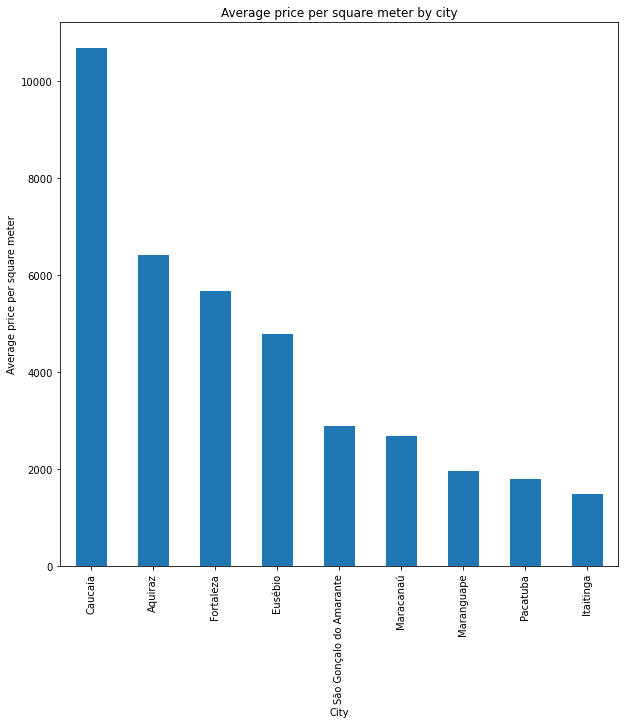

In [75]:
#So we can check the city with the average price per square meter
df_Properties3.groupby('City')['Price_Square_Meter'].mean().sort_values(ascending=False).plot.bar(title = 'Average price per square meter by city'
                                                                                                  ,xlabel = 'City'
                                                                                                  ,ylabel='Average price per square meter'
                                                                                                  ,figsize=(10,10))

<AxesSubplot:title={'center':'Quantity of properties for sale by city'}, xlabel='City', ylabel='Quantity of properties for sale'>

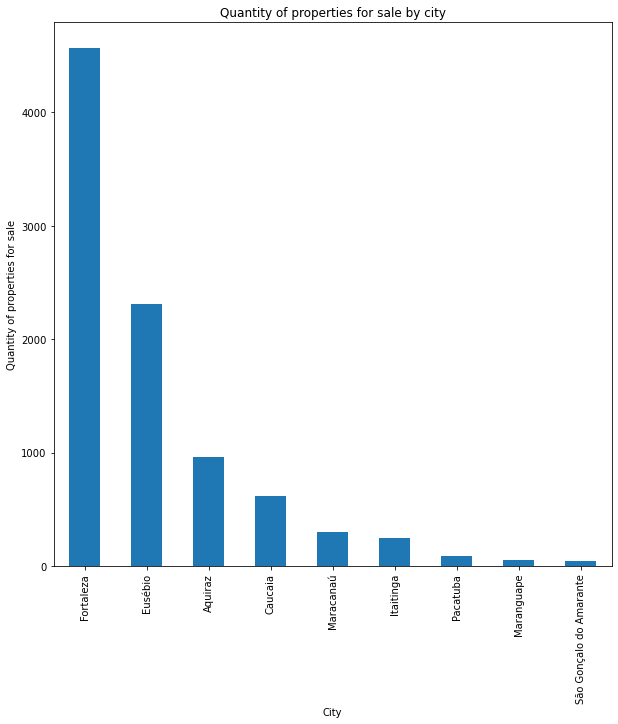

In [73]:
#Quantity of properties for sale by city
df_Properties3.groupby('City')['Price_Value'].count().sort_values(ascending=False).plot.bar(title = 'Quantity of properties for sale by city'
                                                                                                  ,xlabel = 'City'
                                                                                                  ,ylabel='Quantity of properties for sale'
                                                                                                  ,figsize=(10,10))

<AxesSubplot:title={'center':'Average Price by city'}, xlabel='City', ylabel='Average Price'>

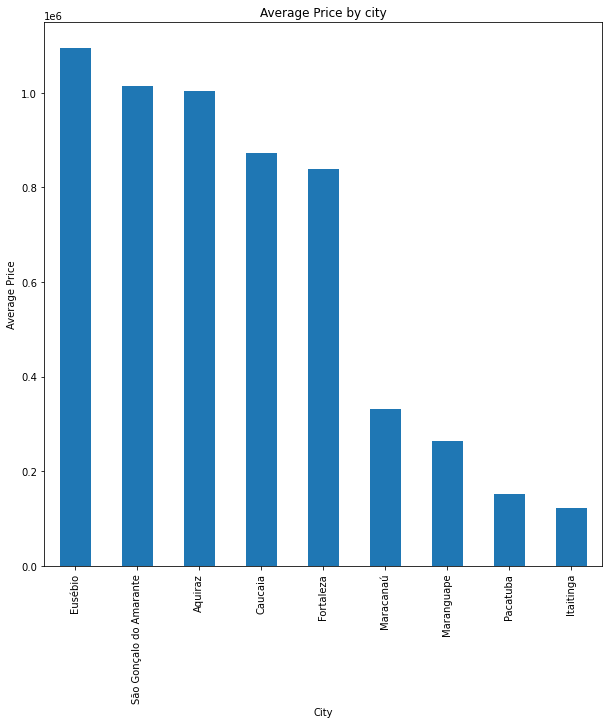

In [74]:
#Average Price of the Properties per city
df_Properties3.groupby('City')['Price_Value'].mean().sort_values(ascending=False).plot.bar(title = 'Average Price by city'
                                                                                                  ,xlabel = 'City'
                                                                                                  ,ylabel='Average Price'
                                                                                                  ,figsize=(10,10))